In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.io import IO
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    HardPhongShader,
    TexturesUV,
    PointLights,
    TexturesAtlas,
    TexturesVertex,
)
import trimesh

In [2]:
CURDIR = os.path.dirname(os.path.abspath("__file__"))
CURDIR

'/nfs/nfs2/home/nhaldert/work_dir/3d-image-generation/src'

In [17]:
def normalize_mesh_torch(verts):
    min_xyz = verts.min(dim=0).values
    max_xyz = verts.max(dim=0).values
    center = 0.5 * (min_xyz + max_xyz)
    scale = (max_xyz - min_xyz).max()
    verts_normalized = (verts - center) / scale
    return verts_normalized

In [4]:
device = "cpu"

In [14]:
mesh_path = os.path.join(CURDIR, "model.obj")
texture_path = os.path.join(CURDIR, "texture.png")

mesh = load_objs_as_meshes([mesh_path], device=device, load_textures=True)

# tx = TexturesVertex()


# verts = mesh.verts_packed()
# N = verts.shape[0]
# center = verts.mean(0)
# scale = max((verts - center).abs().max(0)[0])
# mesh.offset_verts_(-center)
# mesh.scale_verts_((1.0 / float(scale)))

In [19]:
verts = mesh.verts_packed()
mesh = Meshes(verts=[normalize_mesh_torch(verts)], faces=[mesh.faces_packed()], textures=mesh.textures)

(-0.5, 1023.5, 1023.5, -0.5)

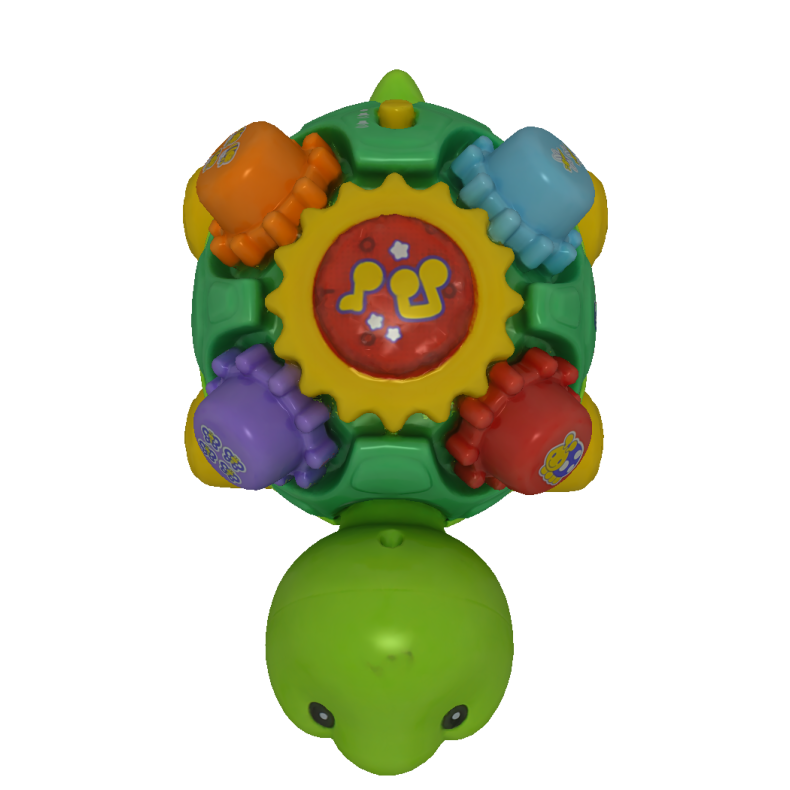

In [25]:
R, T = look_at_view_transform(1, 0, 0)  # distance, ele in auxvation, azimuth
cameras = FoVPerspectiveCameras(fov=60, device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[0.0, 0.0, 2.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")